# Optimization via Polynomials

<h3> Nicholas Wong </h3>
<h4> University of Cambridge </h4>

In [1]:
%matplotlib inline
from equadratures import *
import numpy as np

In optimization algorithms, search methods often require multiple evaluations of the objective function and its gradient at different points. For this purpose, speeding up the evaluations will significantly improve the runtime of such algorithms. Built around this rationale, the Effective Quadratures library currently includes optimization routines that integrates optimization algorithms with function evaluation with the polynomial approximation model.

Currently, the $\texttt{polyopt.py}$ module includes two methods of optimization: "Vanilla" steepest descent (SD) and Sequentia Least Squares Prgramming (SLSQP), using scipy.optimize.minimize. While SD is more of a proof of concept, SLSQP is effective in finding the optimum of the function provided the degree of polynomial used is sufficient, and can incorporate constraints both from user input and implied through input variable ranges. 

<h2> Example Use </h2>

Consider the Rosenbrock function in 2-D:

$$ f(x_0, x_1) = (1 - x_0)^2 + 100(x_1 - x_0^2)^2, $$

which has a minimum of 0 at $(x_0, x_1) = (1, 1)$.


In [2]:
def rosenbrock_fun(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

Defining the variables as standard Gaussian variables and compute the polynomial expansion coefficients to initialize the polyopt class:

In [3]:
degree = 5
points_used = degree + 1
x0 = Parameter(param_type="Gaussian", shape_parameter_A = 0.0, shape_parameter_B = 1.0, points=points_used, derivative_flag = 1)
x1 = Parameter(param_type="Gaussian", shape_parameter_A = 0.0, shape_parameter_B = 1.0, points=points_used, derivative_flag = 1)
parameters = [x0,x1]
basis = IndexSet('Tensor grid',[degree,degree])
uqProblem = Polyint(parameters,basis)
coefficients, indices, pts = uqProblem.getPolynomialCoefficients(rosenbrock_fun)
opt = Polyopt(coefficients, basis, parameters)

There are no constraints implied by the variables here, since the support for Gaussian variables spans the real line. Now, let's try using SD (which can handle unconstrained optimization) to optimize the function, with a starting point at (-1.5, -1):

In [4]:
final_val, final_vars, num_evals = opt.SD(100, init_guess = [-1.5,1], convergence = .1)
print final_val, final_vars, num_evals

[ 0.11205035] [ 0.66709107  0.44151479] 100


Since this is a 2-D function, we can also plot the function contours and optimization trajectory. In the line below, the arguments define the x and y range of the plot:

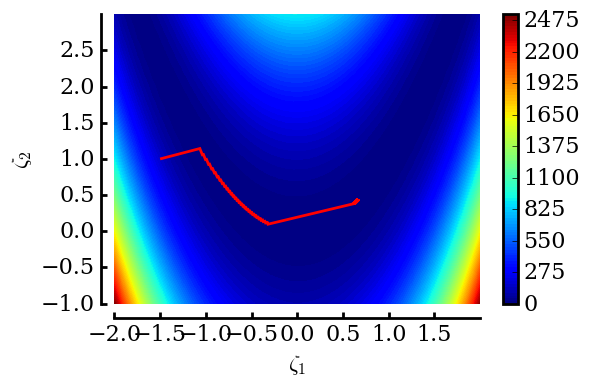

In [5]:
opt.cont_plot(-2,2,-1,3)

It seems that the SD algorithm is stuck somewhere near the minimum with low gradients. Let's see if SLSQP will fare better:

Optimization terminated successfully.    (Exit mode 0)
            Current function value: [  2.26238969e-08]
            Iterations: 36
            Function evaluations: 49
            Gradient evaluations: 36
[  2.26238969e-08] [ 0.99995643  0.99989846] 36


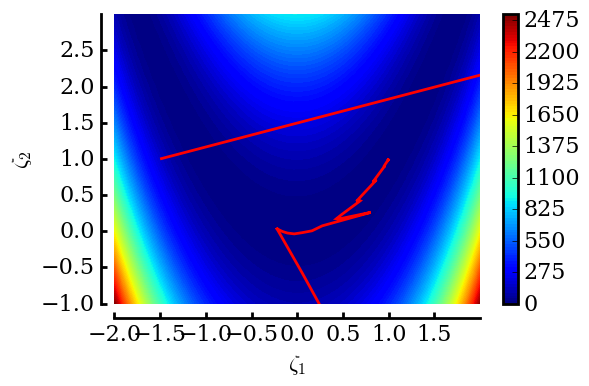

In [6]:
final_val, final_vars, num_evals = opt.SLSQP(100, init_guess = [-1.5,1], convergence = .1)
print final_val, final_vars, num_evals
opt.cont_plot(-2,2,-1,3)

With much more sophistication, it is no surprise that the scipy SLSQP routine works better. Now, instead of Gaussian variables, let's use uniform variables, this implying an implicit constraint on the optimization problem:

In [7]:
x0 = Parameter(param_type="Uniform", lower=0.0, upper=0.5, points=points_used, derivative_flag = 1)
x1 = Parameter(param_type="Uniform", lower=1.0, upper=2.0, points=points_used,derivative_flag = 1)
parameters = [x0,x1]
uqProblem = Polyint(parameters,basis)
coefficients, indices, pts = uqProblem.getPolynomialCoefficients(rosenbrock_fun)
opt = Polyopt(coefficients, basis, parameters)

In addition, we add the constraint that $x_1$ must be larger than 1.1, for example. Initialize the optimization at a feasible point (0, 2) and run the optimization with SLSQP, remembering that the additional constraints must be placed in a list:

Optimization terminated successfully.    (Exit mode 0)
            Current function value: [ 72.50000026]
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
[ 72.50000026] [ 0.5  1.1] 2


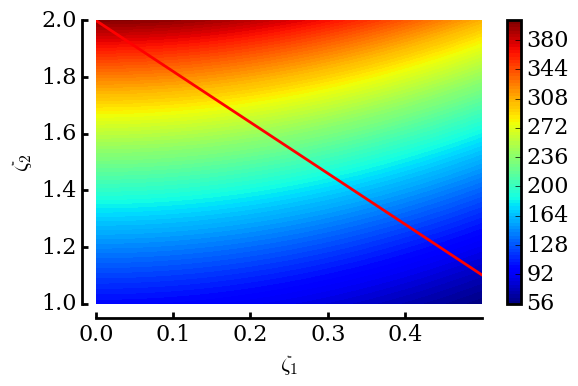

In [8]:
c1 = {'type' : 'ineq',
       'fun' : lambda x: np.array([x[1] - 1.1]),
       'jac': lambda x: np.array([0.0, 1.0])}

final_val, final_vars, num_evals = opt.SLSQP(100, init_guess = [0.0,2.0], convergence = .1, add_cons = [c1])
print final_val, final_vars, num_evals
opt.cont_plot(0,0.5,1,2)

From the contour plot we can clearly see the minimum lies in the lower right hand corner, and that is what we get from the optimization results.